In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geocoder as gc
import seaborn as sns

Let's load our data and take our first peek.

In [2]:
restaurants = pd.read_csv('../../datasets/restaurants.csv')

In [3]:
restaurants.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,03/30/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection


In [4]:
restaurants.shape

(399918, 18)

In [5]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399918 entries, 0 to 399917
Data columns (total 18 columns):
CAMIS                    399918 non-null int64
DBA                      399559 non-null object
BORO                     399918 non-null object
BUILDING                 399809 non-null object
STREET                   399909 non-null object
ZIPCODE                  399909 non-null float64
PHONE                    399913 non-null object
CUISINE DESCRIPTION      399918 non-null object
INSPECTION DATE          399918 non-null object
ACTION                   398783 non-null object
VIOLATION CODE           393414 non-null object
VIOLATION DESCRIPTION    392939 non-null object
CRITICAL FLAG            399918 non-null object
SCORE                    376704 non-null float64
GRADE                    195413 non-null object
GRADE DATE               192820 non-null object
RECORD DATE              399918 non-null object
INSPECTION TYPE          398783 non-null object
dtypes: float64(2), int6

Note that there are two float fields (the ZIPCODE and the SCORE), one integer field (the CAMIS, a unique identifier for each restaurant), and the rest of the fields are text fields, read in as objects. We have ~400k instances in our data set.
Also note that there are two fields missing substantial amounts of data: GRADE and GRADE DATE. Apparently less than half of the included inspections resulted in a grade assignment.

## Doing some cleaning

In [6]:
# Let's get rid of columns we know we won't need, like ACTION and PHONE. 
cols_to_del = ['ACTION', 'PHONE', 'RECORD DATE', 'INSPECTION TYPE']
def del_cols(dataframe, cols_to_del):
    return dataframe.drop(cols_to_del, axis=1)

restaurants = del_cols(restaurants, cols_to_del)

In [7]:
# Let's find out which columns are incomplete.
def check_col_complete(dataframe):
    len_ = len(dataframe)

    incomplete = []
    for col in dataframe.columns:
        complete = dataframe[col].count() == len_
        if complete:
            print('{: >23}: COMPLETE'.format(col))
        else:
            missing = len_ - dataframe[col].count()
            incomplete.append(col)
            print('{: >23}: MISSING {} VALUES ({:.1f}%)'.format(col, missing, missing*100/len_))
    
    print('\nTotal number of items:', len_)

    return incomplete

incomplete_cols = check_col_complete(restaurants)

                  CAMIS: COMPLETE
                    DBA: MISSING 359 VALUES (0.1%)
                   BORO: COMPLETE
               BUILDING: MISSING 109 VALUES (0.0%)
                 STREET: MISSING 9 VALUES (0.0%)
                ZIPCODE: MISSING 9 VALUES (0.0%)
    CUISINE DESCRIPTION: COMPLETE
        INSPECTION DATE: COMPLETE
         VIOLATION CODE: MISSING 6504 VALUES (1.6%)
  VIOLATION DESCRIPTION: MISSING 6979 VALUES (1.7%)
          CRITICAL FLAG: COMPLETE
                  SCORE: MISSING 23214 VALUES (5.8%)
                  GRADE: MISSING 204505 VALUES (51.1%)
             GRADE DATE: MISSING 207098 VALUES (51.8%)

Total number of items: 399918


We're missing quite a few entries for SCORE, GRADE, and GRADE DATE. We're missing a small (<2%) number of entries for VIOLATION CODE and VIOLATION DESCRIPTION. We're only missing a few entries for address and name of restaurante (DBA).

In [8]:
# Let's get rid of missing value instances for all the columns with less than 2% missing data.
# restaurants = restaurants.dropna(subset=['BUILDING', 'STREET', 'ZIPCODE'])
restaurants = restaurants.dropna(subset=incomplete_cols[:-3])

In [9]:
# Recheck for missing entries.
missing = check_col_complete(restaurants)

                  CAMIS: COMPLETE
                    DBA: COMPLETE
                   BORO: COMPLETE
               BUILDING: COMPLETE
                 STREET: COMPLETE
                ZIPCODE: COMPLETE
    CUISINE DESCRIPTION: COMPLETE
        INSPECTION DATE: COMPLETE
         VIOLATION CODE: COMPLETE
  VIOLATION DESCRIPTION: COMPLETE
          CRITICAL FLAG: COMPLETE
                  SCORE: MISSING 18159 VALUES (4.6%)
                  GRADE: MISSING 198638 VALUES (50.6%)
             GRADE DATE: MISSING 201203 VALUES (51.2%)

Total number of items: 392841


In [10]:
# Before continuing, let's fix some of these data types to be easier to work with.
restaurants['INSPECTION DATE'] = pd.to_datetime(restaurants['INSPECTION DATE'], infer_datetime_format=True)
restaurants['GRADE DATE'] = pd.to_datetime(restaurants['GRADE DATE'], infer_datetime_format=True)
restaurants['ZIPCODE'] = restaurants['ZIPCODE'].astype(int)
restaurants['CRITICAL FLAG'] = restaurants['CRITICAL FLAG'].astype('category')

In [11]:
# Recheck data types
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392841 entries, 0 to 399917
Data columns (total 14 columns):
CAMIS                    392841 non-null int64
DBA                      392841 non-null object
BORO                     392841 non-null object
BUILDING                 392841 non-null object
STREET                   392841 non-null object
ZIPCODE                  392841 non-null int64
CUISINE DESCRIPTION      392841 non-null object
INSPECTION DATE          392841 non-null datetime64[ns]
VIOLATION CODE           392841 non-null object
VIOLATION DESCRIPTION    392841 non-null object
CRITICAL FLAG            392841 non-null category
SCORE                    374682 non-null float64
GRADE                    194203 non-null object
GRADE DATE               191638 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](2), float64(1), int64(2), object(8)
memory usage: 42.3+ MB


It looks like VIOLATION DESCRIPTION may be equivalent to the VIOLATION CODE provided, in which case we can create  a dictionary of violations and delete that column. Let's find out.

In [12]:
restaurants[['VIOLATION CODE', 'VIOLATION DESCRIPTION']].describe()

,VIOLATION CODE,VIOLATION DESCRIPTION
count,392841,392841
unique,93,93
top,10F,Non-food contact surface improperly constructe...
freq,55772,55772


In [13]:
violation_dict = pd.Series(restaurants['VIOLATION DESCRIPTION'].values, 
                           index=restaurants['VIOLATION CODE']).to_dict()
len(violation_dict)

93

The dictionary we created has the same number of unique values, so we know these two columns are equivalent.

In [14]:
# Delete redundant column.
restaurants = restaurants.drop('VIOLATION DESCRIPTION', axis=1)

## Exploring our data

In [15]:
# Let's get some statistics about our data set.
print('Unique restaurants: {}'.format(len(set(restaurants['CAMIS']))))
print('Date range: {} to {}'.format(restaurants['INSPECTION DATE'].min(), restaurants['INSPECTION DATE'].max()))

Unique restaurants: 25293
Date range: 2011-10-07 00:00:00 to 2017-08-26 00:00:00


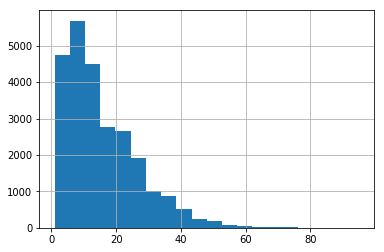

In [16]:
# Histogram of the number of violations per restaurant.
restaurants['CAMIS'].value_counts().hist(bins=20)

In [17]:
# Let's see the top ten offenders
worst_offenders = restaurants['CAMIS'].value_counts()[:10]
worst_offenders

41683816    95
50001880    95
50033122    91
40965177    91
41459659    90
41510846    89
41289382    87
41630632    84
41528486    77
50003580    76
Name: CAMIS, dtype: int64

Two restaurants have the honor of having the greatest number of violations in the dataset. Let's find out who they are and where they're located.

In [18]:
# Save list of the CAMIS values for the worst offenders
worst_offender_IDs = worst_offenders[:5].index

In [19]:
# Find the fist entry for each restaurant on our list
inds = []
for ID in worst_offender_IDs:
    inds.append(restaurants[restaurants['CAMIS']==ID].index[0])
restaurants.loc[inds]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION CODE,CRITICAL FLAG,SCORE,GRADE,GRADE DATE
6273,41683816,MAX BAKERY & RESTAURANT,QUEENS,3763,90 STREET,11372,Chinese,2017-06-07,10B,Not Critical,34.0,C,2017-06-07
455,50001880,GANG SAN DEUL,QUEENS,248-25,NORTHERN BLVD,11362,Korean,2015-05-05,06D,Critical,19.0,NaN,NaT
3593,50033122,PARTY WELL REST & ORIENTAL BAKERY,QUEENS,14932,41ST AVE,11355,Korean,2017-03-07,10B,Not Critical,19.0,NaN,NaT
7065,40965177,LA GATA GOLOSA #2,QUEENS,8901,37 AVENUE,11372,Bakery,2016-12-09,10F,Not Critical,3.0,NaN,NaT
3538,41459659,T. K. KITCHEN,MANHATTAN,26,SAINT MARKS PLACE,10003,Asian,2015-08-10,02G,Critical,34.0,NaN,NaT


Things are not looking great for Queens in our cursory review so far. We'll see if that plays out when we look at the number of violations by borough in a bit, but we should keep in mind that higher restaurant turnover (which would be expected in Manhattan) would decrease the likelihood of showing up on this list.
The top two offenders are tied with 93 citations, but the second restaurant has a SCORE of 19 compared to 34 for the first, so we'll consider the second restaurant, Gang San Deul, the winner (loser?). Let's dig in a bit deeper on the worst offender in New York before moving on. 

In [20]:
# Let's narrow our sights on this restaurant.
ID = worst_offender_IDs[1]
worst = restaurants[restaurants['CAMIS']==ID]
worst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 455 to 391630
Data columns (total 13 columns):
CAMIS                  95 non-null int64
DBA                    95 non-null object
BORO                   95 non-null object
BUILDING               95 non-null object
STREET                 95 non-null object
ZIPCODE                95 non-null int64
CUISINE DESCRIPTION    95 non-null object
INSPECTION DATE        95 non-null datetime64[ns]
VIOLATION CODE         95 non-null object
CRITICAL FLAG          95 non-null category
SCORE                  92 non-null float64
GRADE                  47 non-null object
GRADE DATE             47 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 9.8+ KB


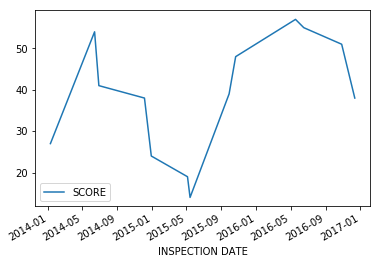

In [21]:
# It's received 92 scores. Let's see what they are.
worst[worst['SCORE'].notnull()].plot(x='INSPECTION DATE', y='SCORE')

In [22]:
# What were the violations?
v_counts = worst['VIOLATION CODE'].value_counts()
v_codes = worst['VIOLATION CODE'].value_counts().index
for count, code in list(zip(v_counts, v_codes))[:5]:
    print(count, code, violation_dict[code][:100], '...')

10 02B Hot food item not held at or above 140Âº F. ...
9 04N Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food ...
8 08A Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises an ...
7 06A Personal cleanliness inadequate. Outer garment soiled with possible contaminant.  Effective hair res ...
6 02G Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except ...


I'll probably be staying clear of this place.

Let's zoom out a bit and take a look at geographical information. First let's get GPS coordinates from our addresses. This is called 'forward geocoding.'

Since we have far more entries than number of restaurants, it would be wasteful to geocode each item in our dataset. Instead we'll create a list of unique addresses and look each one up once.

In [23]:
addresses = (restaurants['BUILDING'] + ' ' + restaurants['STREET'] + 
             ', ' + restaurants['BORO'] + ', NY ' + restaurants['ZIPCODE'].astype(str))
addresses = list(set(addresses))

print(addresses[:5])
print()
print(len(addresses))

['3441 VICTORY BOULEVARD, STATEN ISLAND, NY 10314', '1568 2 AVENUE, MANHATTAN, NY 10028', '3401 CHURCH AVENUE, BROOKLYN, NY 11203', '1613 2ND AVE, MANHATTAN, NY 10028', '145 MULBERRY STREET, MANHATTAN, NY 10013']

23091


It will take a long time to fetch GPS coordinates for all of our restaurants, but we can take a random sample in a reasonable amount of time. For the sake of doing this once, coordinates will be saved in a pickle file.

In [24]:
sample_size = len(addresses)
random_inds = np.random.permutation(len(addresses))
random_sample = [addresses[ind] for ind in random_inds[:sample_size]]

In [25]:
import progressbar
import pickle
import time
COORDS_PATH = 'gps_coords.pkl'

def get_coords(addresses, address_to_coords=None):
    
    api_key = '9GOLlJifpGuxjGPy2519C6NkcmtXxAYM'
    if address_to_coords is None:
        address_to_coords = {}

    # Create a progress bar
    widgets = [
            'Progress: ', progressbar.Percentage(),
            ' ', progressbar.Bar(),
            ' ', progressbar.ETA(),
            ]
    bar = progressbar.ProgressBar(widgets=widgets, max_value=len(addresses)).start()

    # Loop through batch of addresses calling geocoding API for each
    for i, address in enumerate(addresses):
        g = gc.mapquest(address, key=api_key)
        if g.status_code==200:
            latitude, longitude = g.latlng
        else:
            latitude, longitude = np.nan, np.nan
        address_to_coords[address] = (latitude, longitude)
#         print(latitude, longitude)
        time.sleep(0.5)
        bar.update(i+1)
    
    bar.finish()

    return address_to_coords

In [26]:
from threading import Thread

def threaded_geocode(nthreads, addresses, fetch_new=False, coords_path=COORDS_PATH):
    if fetch_new:
        """process the id range in a specified number of threads"""
        address_to_coords = {}
        threads = []
        
        # create the threads
        for i in range(nthreads):
            address_subset = addresses[i::nthreads]
            t = Thread(target=get_coords, args=(address_subset, address_to_coords))
            threads.append(t)

        [t.start() for t in threads] # start the threads
        [t.join() for t in threads] # wait for the threads to finish
        
        # Save results to pickle file so we don't have to repeat this.
        pickle.dump(address_to_coords, file=open(coords_path, 'wb'))
        
    else:
        address_to_coords = pickle.load(file=open(coords_path, 'rb'))
        
    return address_to_coords

In [27]:
address_to_coords = threaded_geocode(32, random_sample, fetch_new=False)
print('Gathered {} geocoordinates'.format(len(address_to_coords)))

Gathered 23091 geocoordinates


In [28]:
def get_latslongs(address_to_coords):
    latitudes, longitudes = [], []
    for latitude, longitude in address_to_coords.values():
        latitudes.append(latitude)
        longitudes.append(longitude)
    return latitudes, longitudes

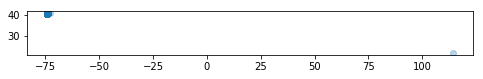

In [29]:
lats, longs = get_latslongs(address_to_coords)

# Let's plot our sampled coordinates
plt.figure(figsize=(8, 8))
plt.scatter(longs, lats, alpha=0.3)
plt.gca().set_aspect('equal')

Let's get rid of that outlier on the bottom right.

In [30]:
address_to_coords = {k:v for k, v in address_to_coords.items() if v[1] < -73.6}

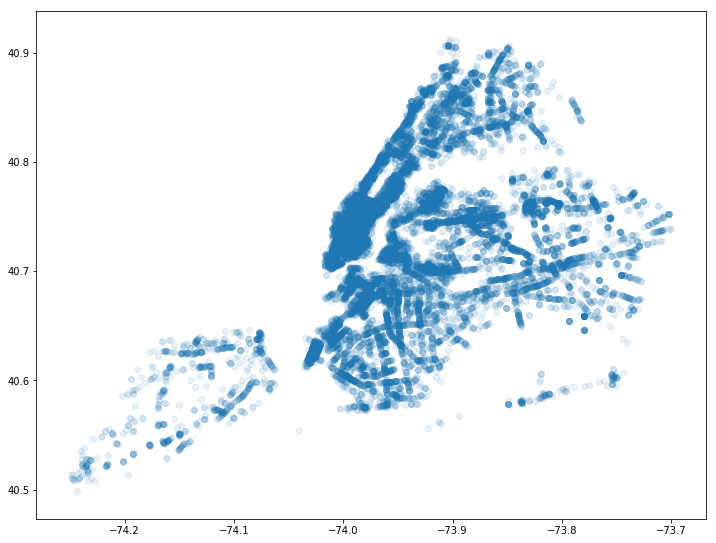

In [52]:
# Replot
lats, longs = get_latslongs(address_to_coords)

fig = plt.figure(figsize=(12, 12))
plt.scatter(longs, lats, alpha=0.1)
plt.gca().set_aspect('equal')
fig.savefig('NYCdensity.png', dpi=300)

Let's make this plot more useful by laying it over a map of the city.

In [32]:
import matplotlib.image as mpimg
nyc_img = mpimg.imread('nyc_map.png')

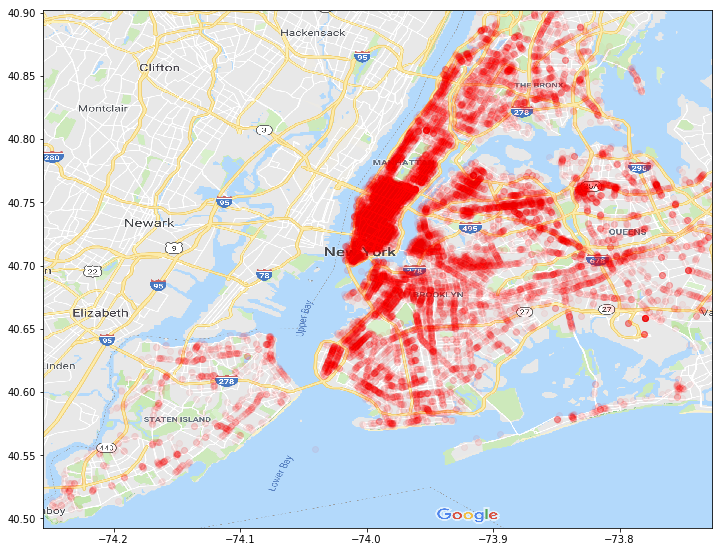

In [33]:
plt.figure(figsize=(12,12))
ax = plt.scatter(longs, lats, alpha=0.05, color='red')
map_extent = [-74.256140, -73.726629, 40.492626, 40.901802]
plt.imshow(nyc_img, extent=map_extent, alpha=1) # The coordinates of my Google Maps screenshot.
plt.gca().set_aspect('equal')
plt.show()

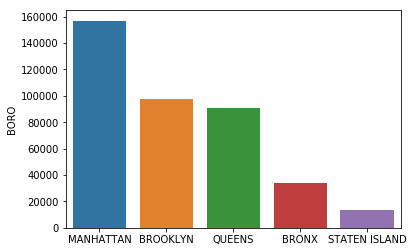

In [34]:
# Now let's see how the boroughs compare. 
import seaborn as sns
violations_per_boro = restaurants['BORO'].value_counts()
sns.barplot(x=violations_per_boro.index, y=violations_per_boro)

[('QUEENS', 15.854923184357542), ('BROOKLYN', 15.701190093277582), ('MANHATTAN', 15.50677212061295), ('BRONX', 14.789224137931035), ('STATEN ISLAND', 14.508771929824562)]


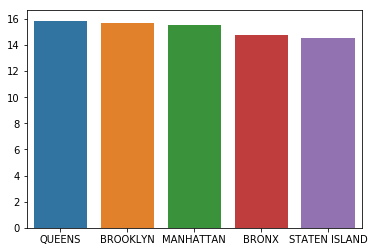

In [35]:
# How about the average number of violations per restaurant?
boros = restaurants['BORO'].unique()
avg_viol_boros = []
for boro in boros:
    num_restaurants = len(set(restaurants[restaurants['BORO']==boro]['CAMIS']))
    num_violations = violations_per_boro.loc[boro]
    avg_viol_boros.append(num_violations/num_restaurants)
    
sorted_ = sorted(zip(boros, avg_viol_boros), key=lambda x:x[1], reverse=True)
boros = [item[0] for item in sorted_]
avg_viol_boros = [item[1] for item in sorted_]
    
sns.barplot(boros, avg_viol_boros)
print(sorted_)

Queens has the highest number of violations per restaurant (by a small lead) in the dataset, but remember our earlier caveat that boroughs with less turnover are likelier to have higher values here, since restaurants will continue to appear in the dataset for a longer duration.

In [36]:
# Let's compare different cuisines. 
restaurants['CUISINE DESCRIPTION'].describe()

count       392841
unique          84
top       American
freq         89465
Name: CUISINE DESCRIPTION, dtype: object

We have 84 unique restaurant descriptions. Let's explore a bit further.

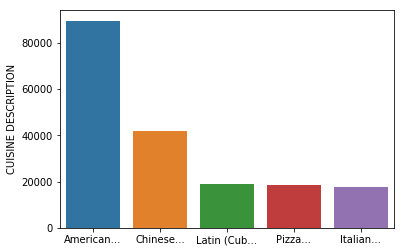

In [37]:
cuisine_counts = restaurants['CUISINE DESCRIPTION'].value_counts()
a = sns.barplot(x=[str_[:10]+'...' for str_ in cuisine_counts.index[:5]], y=cuisine_counts[:5])

So American restaurants have the greatest number of violations with more than double the number of the next most frequent cuisine Chinese, and Chinese restaurants in turn appear more than twice as much as pizza restaurants.
From our data set we have no indication of which cuisine is most popular in the city, so we cannot make firm conclusions about the number of violations per restaurant, only number of violations per restaurant in our data set, as discussed above. 

In [38]:
restaurants['CUISINE DESCRIPTION'].value_counts().tail()

Polynesian            48
Nuts/Confectionary    40
Czech                 33
Californian           29
Soups                 28
Name: CUISINE DESCRIPTION, dtype: int64

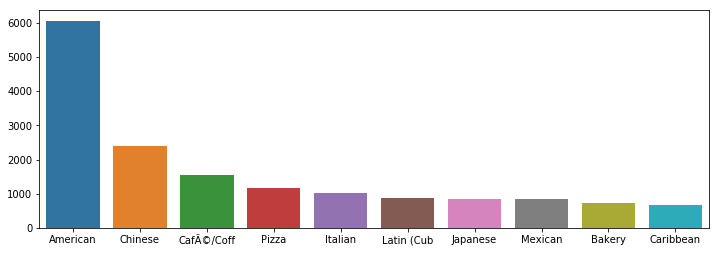

In [39]:
# We'll restrict our analysis to the 20 most appearing cuisines to make the data more reliable.
cuisines = cuisine_counts.index[:10]
viol_per_restaurant_cuisine = []
for cuisine in cuisines:
    cuisine_num = cuisine_counts[cuisine]
    resturant_num = len(set(restaurants[restaurants['CUISINE DESCRIPTION']==cuisine]['CAMIS']))
    viol_per_restaurant_cuisine.append((cuisine, resturant_num))
    
# Sort by violations per restaurant
viol_per_restaurant_cuisine = sorted(viol_per_restaurant_cuisine, key=lambda x:x[1], reverse=True)
labels = [item[0][:10] for item in viol_per_restaurant_cuisine]
counts = [item[1] for item in viol_per_restaurant_cuisine]
plt.figure(figsize=(12, 4))
ax = sns.barplot(labels, counts)


So American cuisine restaurants have both the most violations in our dataset and the most violations per individual restaurant in our dataset. Chinese restaurants are second with a little more than a third of the violations per restaurant. 
Why is American food so high on this list? It could be that fast food restaurants are bringing up the number of violations, and that they are primarily categorized as 'American' food.

Let's wrap up with a few other questions that come to mind.

In [40]:
# For plotting purposes, we'll shorten the labels for Latin and Coffee restaurants.
cuisines = cuisine_counts.index[:20]
replacements = {cuisines[2]: 'Latin', cuisines[5]: 'Coffee'}
restaurants['CUISINE DESCRIPTION'] = restaurants['CUISINE DESCRIPTION'].replace(replacements)
cuisines = list(cuisines)
cuisines[2] = 'Latin'
cuisines[5] = 'Coffee'

In [41]:
# Gather a list of the 20 most popular cuisines, sorted by average score, for use as labels
labels = restaurants[restaurants['CUISINE DESCRIPTION'].isin(cuisines)].groupby(
    'CUISINE DESCRIPTION').mean().sort_values(by='SCORE', ascending=True).index
short_labels = [label[:10] for label in labels]

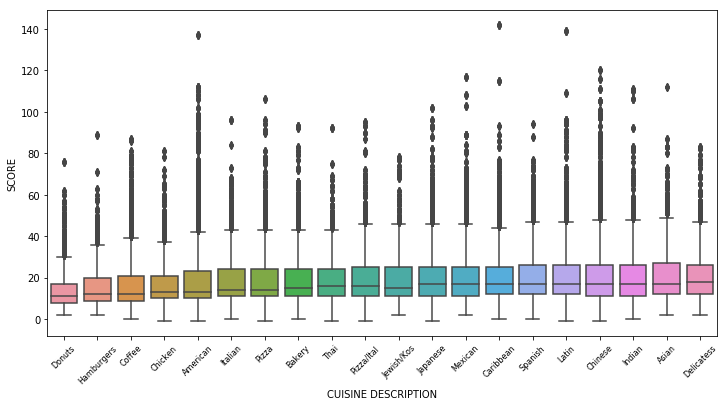

In [42]:
# Now let's make a boxplot of the scores for each of our top 30 cuisines, in ascending order
plt.figure(figsize=(12,6))
bplot = sns.boxplot(x='CUISINE DESCRIPTION', y='SCORE',
           data=restaurants[restaurants['CUISINE DESCRIPTION'].isin(cuisines)], 
                   order=labels)
bplot.set_xlabel('CUISINE DESCRIPTION')
bplot.set_xticklabels(short_labels, rotation=45, fontsize=8)
plt.show()

So of the 30 most popular cuisines, donut restaurants have the lowest average score, and delicatessens have the highest.

In [43]:
# What streets have the most violations?
restaurants['STREET'].value_counts()[:10]

BROADWAY              14521
3 AVENUE               5728
5 AVENUE               4215
2 AVENUE               4195
8 AVENUE               3569
7 AVENUE               3170
ROOSEVELT AVENUE       3157
1 AVENUE               3131
LEXINGTON AVENUE       3077
NORTHERN BOULEVARD     3057
Name: STREET, dtype: int64

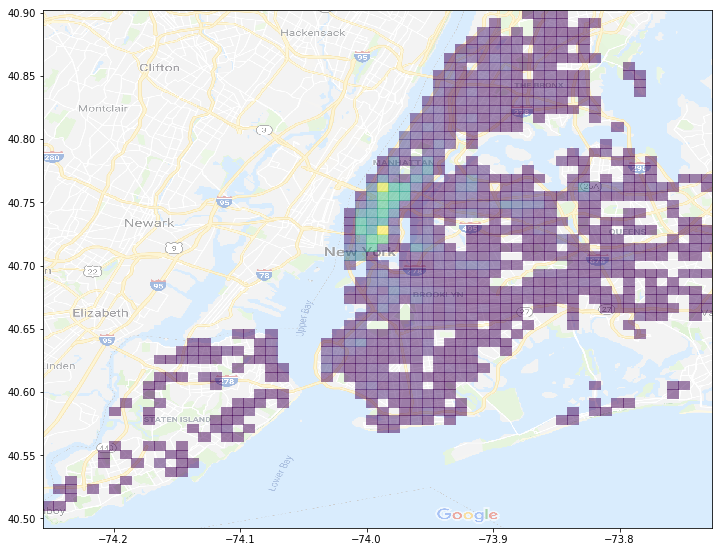

In [44]:
# Let's see a 2D histogram of the number of violations layed over our map.
fig = plt.figure(figsize=(12,12))
plt.hist2d(longs, lats, bins=60, range=[map_extent[:2], map_extent[2:]], alpha=0.5, cmin=3)
plt.imshow(nyc_img, extent=map_extent, alpha=0.5)
plt.show()

## Wrap up

We've loaded, conditioned and explored our dataset. 
We looked at the 'worst offenders' on list. We geocoded our addresses and generated some maps of our data. We compared boroughs, we compared cuisines, and we looked at scores.
Time to unwind and go grab dinner (perhaps not at Gang San Deul).